### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


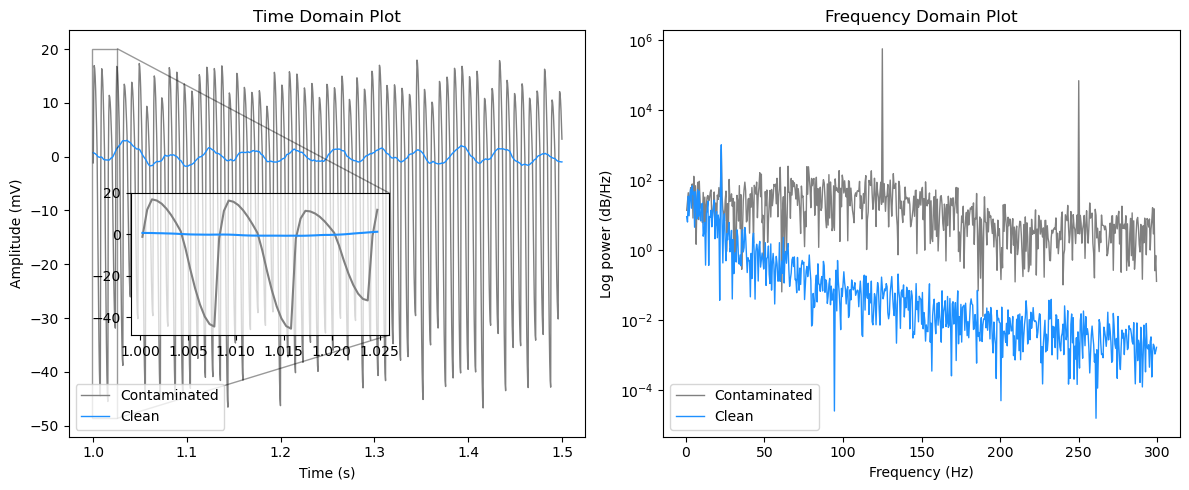

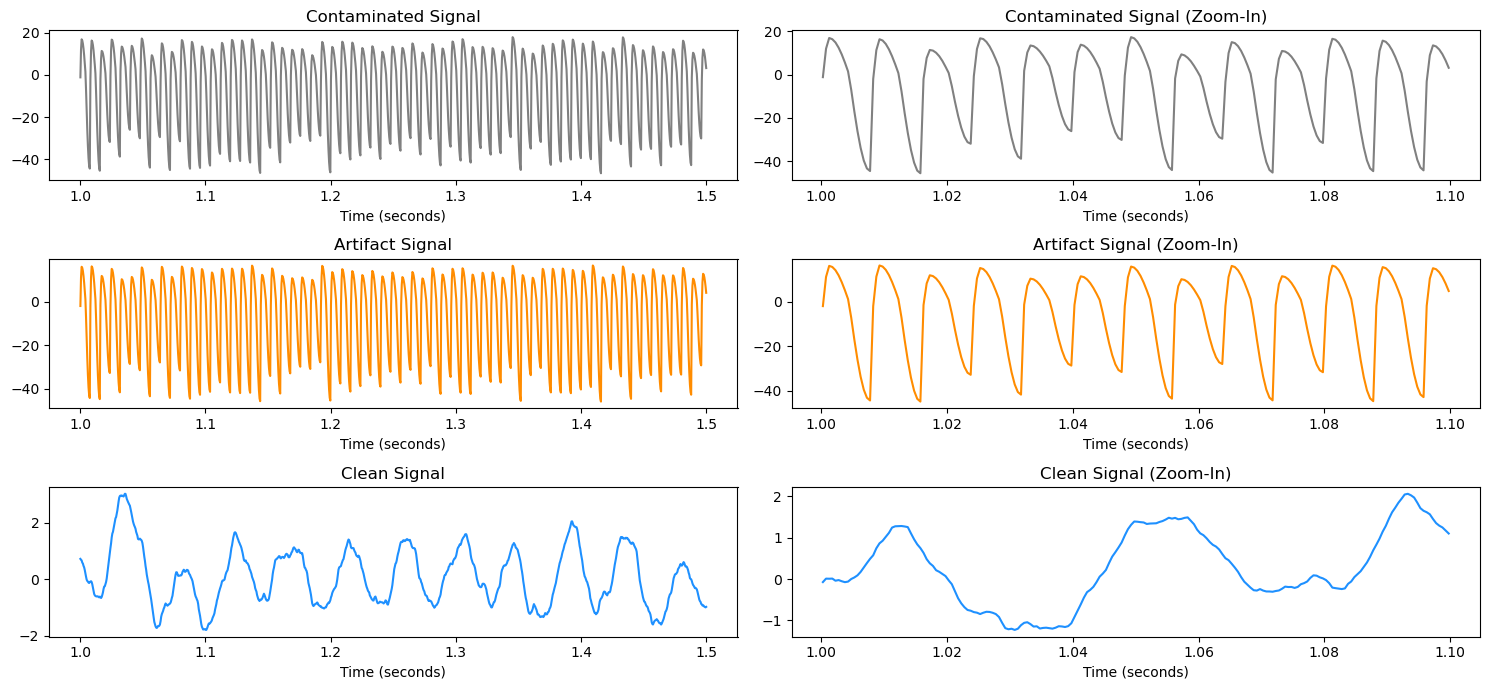

In [2]:
# 데이터 load & plot
datapath = "../../../../data/synthetic_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data[:1000], Clean_data[:1000], standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1]) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 4000)
y_train shape: (800, 1, 4000)
-----------------------------
X_test shape: (200, 1, 4000)
y_test shape: (200, 1, 4000)
-----------------------------


In [5]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [6]:
# 모델 인스턴스 생성
model = CNN().to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [7]:
# 모델 학습
num_epochs = 500

loss_list = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_list.append(epoch_loss)
    if (epoch+1)%5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss}')



Epoch [5/500] | Loss: 0.0025720626302063467
Epoch [10/500] | Loss: 0.002200372228398919
Epoch [15/500] | Loss: 0.0018294018181040884
Epoch [20/500] | Loss: 0.0012212325539439916
Epoch [25/500] | Loss: 0.0006805186741985381
Epoch [30/500] | Loss: 0.0004668180295266211
Epoch [35/500] | Loss: 0.00036748861777596175
Epoch [40/500] | Loss: 0.00028187792166136207
Epoch [45/500] | Loss: 0.00023945120221469552
Epoch [50/500] | Loss: 0.00019616527541074902
Epoch [55/500] | Loss: 0.00016895312524866312
Epoch [60/500] | Loss: 0.00014935983810573816
Epoch [65/500] | Loss: 0.00013185320480260998
Epoch [70/500] | Loss: 0.00022851436282508074
Epoch [75/500] | Loss: 0.00013016995653742925
Epoch [80/500] | Loss: 0.00011363818019162864
Epoch [85/500] | Loss: 0.00013241892302175983
Epoch [90/500] | Loss: 0.00012024913681671023
Epoch [95/500] | Loss: 9.737616957863793e-05
Epoch [100/500] | Loss: 0.00010491572669707238
Epoch [105/500] | Loss: 9.415340755367652e-05
Epoch [110/500] | Loss: 0.0001001338366768

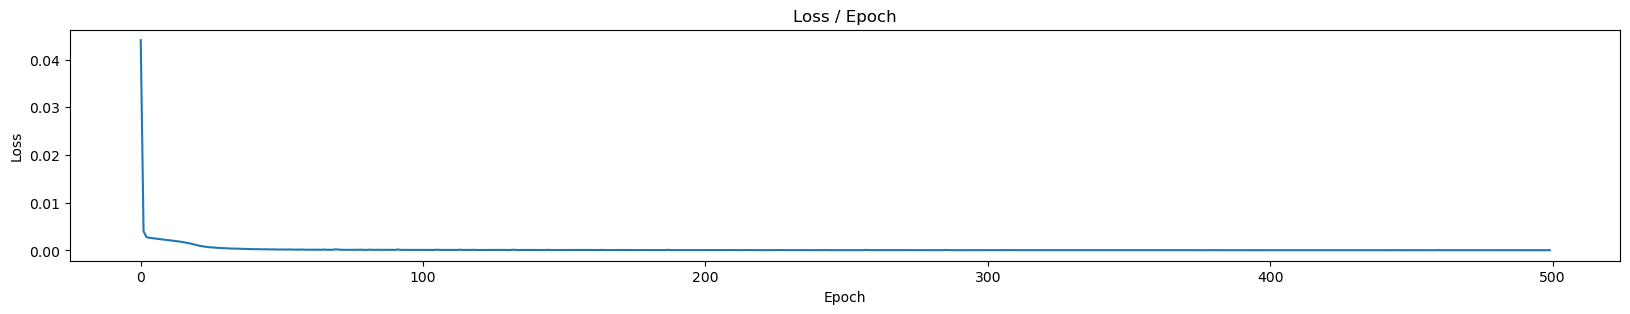

Minimal Loss: 3.7519119650823996e-05 [462]



In [8]:
# Train Loss Plot
Loss_Plot(loss_list)

In [9]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss += loss.item() * x.size(0)

        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss}')

Test Loss: 4.146377643337473e-05


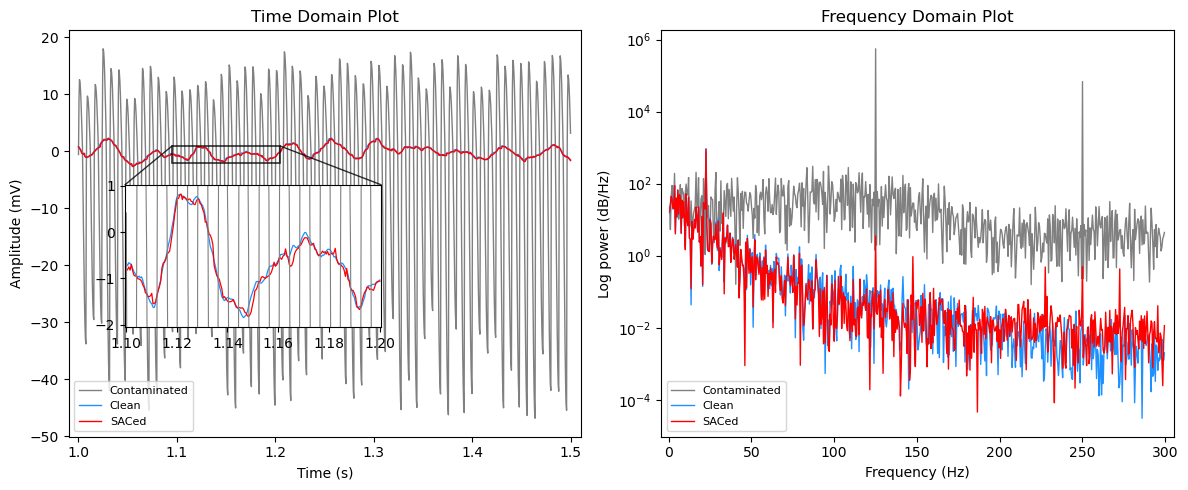

< MSE >
Time Domain MSE: 0.014344653270527958 ± 0.00170539953821501
Frequency Domain MSE: 1.4135024229779771 ± 0.6001116026505517
Time + Frequency MSE: 2.410240018718344 ± 0.39180279295819165


In [10]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
save_path = '../../../../result/CNN/'
save_title = 'CNN_IO_time_L_time'

Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled, save_path, save_title) # inverse scaled data를 input으로 넣음